# FedAVG
**A Pytorch implementation of the Federated Learning Algorithm FedAvg on MNIST dataset**

## Introduction
Federated learning is a machine learning setting where multiple entities collaborate in solving a machine learning
problem. Each client’s dataset is stored locally and not exchanged or transferred, instead local models are trained on the local data and only the model weights are sent to the central server. Federated Learning represents a possible solution to the problem of data privacy and data security in machine learning.

In this project I implemented the Federated Learning algorithm **FedAvg** formulated by McMahan, et al. [1] which is a first approach to this challange and it is considered as the baseline for Federated Learning.

<img src="images/algo.png" alt="Image Description" width="400" height="400">

Basically the algorithm is divided into two phases: the **Client Update** and the **Server Update**. In the **Client Update** phase, each client trains its local model on its local sample of data for the number of local epochs, using the local batch size. In the **Server Update** phase, the server averages the models weights of all the clients to create a new global model. This global model is then sent to all the clients to start a new round of training. In this way, the server never has access to the raw data but only to the model weights, and the global model is a good approximation of the model that would have been obtained by training on the entire dataset.

## Implementation

I implemented the algorithm using Pytorch and I tested it on the MNIST dataset for semplicity. 

The project is divided into the following files:
- `fedsgd.py`: the main file that contains the implementation of the FedAvg algorithm
- `Client.py`: the file that contains the implementation of the `Client` class
- `Server.py`: the file that contains the implementation of the `Server` class
- `models.py`: the file that contains the implementation of the neural models

### Client
The `Client.py` file contains the implementation of the client class. Each client has its own dataloader, model and optimizer, the learning rate and the number of local epochs can be set by the user. The method `train` implements the **Client Update** phase.

```python
def train(self, num_epochs, patience, params, progress_bar):
    self.model.load_state_dict(params)
    self.model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (x, y) in enumerate(self.data):
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            y_pred = self.model(x)
            loss = self.loss_func(y_pred, y)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()
        progress_bar.update(1)
    progress_bar.set_postfix({"loss": running_loss / len(self.data)})
    return running_loss / len(self.data)
```

### Server
The `Server.py` file contains the implementation of the server class. The server has its own model and a method `aggregate` that implements the **Server Update** phase. Notice that the function does not return the new global model but it updates the model inplace.

```python
def aggregate(self, sample_clients):
    params = [client.get_params() for client in sample_clients]
    avg_params = {}
    for key in params[0].keys():
        avg_params[key] = torch.stack(
            [params[i][key] for i in range(len(params))], 0
        ).mean(0)
    self.model.load_state_dict(avg_params)
```

### Algorithm
Finally the `fedsgd.py` file contains the main function that runs the experiment with the right configuration. The algorithm run for `T` rounds, first the server get the current global model state and then sends it to all the clients. Next the clients train their local model, which they updated to the new one, moving into their local optimizer direction for local epochs step and then they send the model back to the server. The server aggregates the models and sends the new global model to all the clients. At the end of the training the server evaluates the model on the test set.

```python
def fedSgdPar(
    model=Cnn(),
    T=5,                # number of rounds
    K=10,               # number of clients
    C=1,                # fraction of clients
    E=10,               # number of local epochs
    B=128,              # local batch size
    num_samples=1000,   # number of training samples on each client
    lr=0.01,            # learning rate
    weight_decay=10e-6, # weight decay
    patience=5,         # patience for early stopping
    noiid=False,        # non-iid data
    verbose=True
):
    # ... code ...
    clients = []
    for i in range(K):
        client = Client(
            i,
            trainloader[i],
            Cnn() if model.get_type() == "Cnn" else Net(),
            lr=lr,
            weight_decay=weight_decay,
            device=device,
        )
        clients.append(client)
    # ... code ...
    clients_each_round = max(int(K * C), 1)
    early_stopper = EarlyStopper(patience, min_delta=10e-3)
    for r in range(T):
        params = server.get_params()
        progress_bar = tqdm.tqdm(
            total=E * clients_each_round, position=0, leave=False, desc="Round %d" % r
        )
        random_clients = random.sample(clients, clients_each_round)
        joblib.Parallel(n_jobs=8, backend="threading")(
            joblib.delayed(client.train)(E, params, progress_bar)
            for client in random_clients
        )
        server.aggregate(random_clients)
        val_loss, val_acc = server.test(valoader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        if early_stopper.early_stop(val_loss):
            if verbose:
                print("Early stopping")
            break
        if verbose:
            print("Server - Val loss: %.3f, Val accuracy: %.3f" % (val_loss, val_acc))

```

The dataset is splitted into training, validation and test set. The training set is divided into `K` clients, each client has a dataloader that samples `num_samples` samples from the training set. The validation set is used to evaluate the model at the end of each round, while the test set is used to evaluate the model at the end of the training. 

To simulate the parallel training of clients on different devices, I used a thread-pool implementation from the `joblib` module. First I create `K` clients, then I sample `C*K` clients to train at each round.

This implemenation allows to test different configurations of the algorithm. In particular if we set `C = 1`, `E = 1` and `B = inf` we obtain the **FedSGD** algorithm, which is the baseline algorithm for the Federated Learning presented in the paper [1].

## Experiments 

In [37]:
from src.fedsgd import fedSgdPar
from src.models import Net, Cnn
import seaborn as sns
import matplotlib.pyplot as plt
import json

In this section I run some experimenst to test the algorithm on the MNIST dataset. All the experiments were executed on the Apple M1 Pro with CPU 8 core and GPU 16 core. Since the paper explore many configurations, I only tested the best performing configurations in terms of accuracy and communication rounds, because of time constraints and computational cost.

### Baseline FedSGD
With `E=1` and `B=inf` we obtain the **FedSGD** algorithm, where each client run only one train step per round and the server average them. As we can see from the plot below, the algorithm is converging for both models, but it requires more rounds to reach the same accuracy of the **FedAvg** algorithm. I stopped trained the models for 40 rounds, more rounds could improve the accuracy, but the CNN training is very slow.


In [31]:
result_net = fedSgdPar(model=Net(), T=40, K=100, C=0.2, E=1, B=480,
                    num_samples=480, lr=0.1, patience=5, weight_decay=10e-6, noiid=False, verbose=False)

-- Test loss: 0.690, Test accuracy: 0.778 --


In [29]:
result_cnn = fedSgdPar(model=Cnn(), T=40, K=100, C=0.3, E=1, B=480,
                    num_samples=480, lr=0.01, patience=5, weight_decay=10e-6, noiid=False, verbose=False)

-- Test loss: 2.041, Test accuracy: 0.720 --


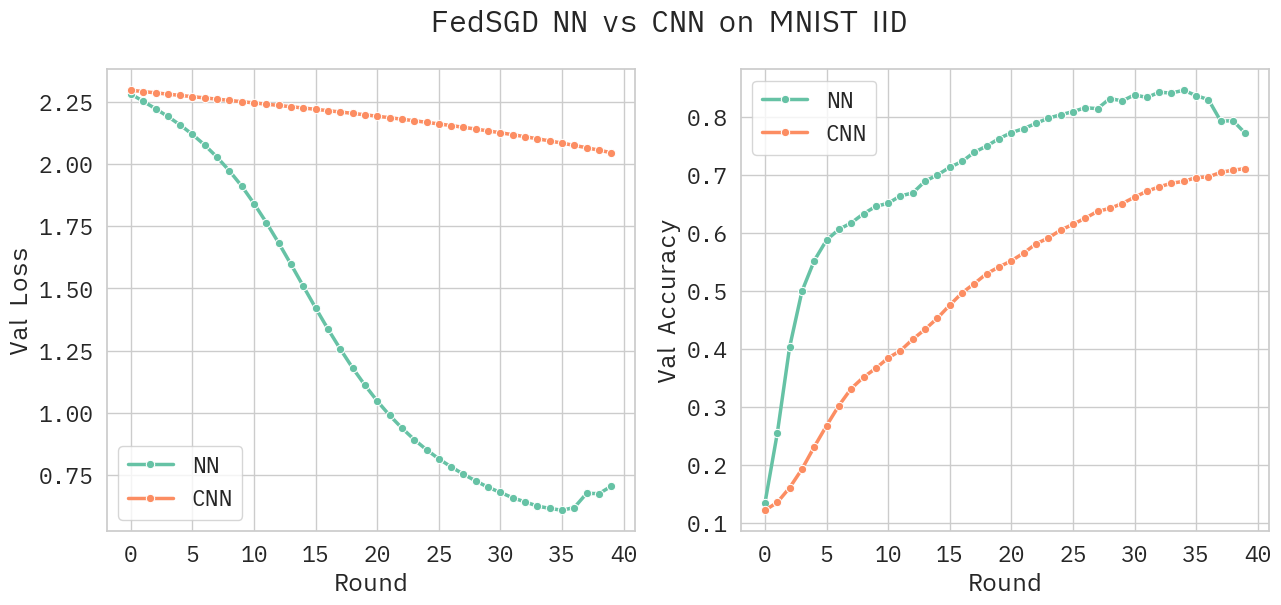

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, 'axes.labelsize': 18})
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams['font.family'] = 'iA Writer Quattro V'
i=0
for result in [result_net, result_cnn]:
    val_losses = result['val_losses']
    val_accs = result['val_accs']

    if i==0: sns.lineplot(x=range(len(val_losses)), y=val_losses, ax=axs[0], color=sns.color_palette()[i], marker='o', label='NN')
    else: sns.lineplot(x=range(len(val_losses)), y=val_losses, ax=axs[0], color=sns.color_palette()[i], marker='o', label='CNN')
    axs[0].set_xlabel('Round')
    axs[0].set_ylabel('Val Loss')

    if i==0: sns.lineplot(x=range(len(val_accs)), y=val_accs, ax=axs[1], color=sns.color_palette()[i], marker='o', label='NN')
    else: sns.lineplot(x=range(len(val_accs)), y=val_accs, ax=axs[1], color=sns.color_palette()[i], marker='o', label='CNN')
    axs[1].set_xlabel('Round')
    axs[1].set_ylabel('Val Accuracy')

    for ax in axs:
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    i+=1

    # title
    plt.suptitle('FedSGD NN vs CNN on MNIST IID')


### FedAvg
Increasing the number of local epochs each client do more steps in the direction of the local optimizer. As shown in [1] using `B=10` we obtain a significant speedup in terms of the number of comunication rounds required to converge to the same test set accuracy. In my case I was able to reach a test set accuracy of 97% in 20 rounds with the NN model and 98% in 20 rounds with the CNN model.

In [33]:
result0 = fedSgdPar(model=Net(), T=20, K=100, C=0.1, E=5, B=10,
                    num_samples=480, lr=0.1, patience=5, weight_decay=10e-5, noiid=False, verbose=False)

-- Test loss: 0.111, Test accuracy: 0.970 --


In [34]:
result1 = fedSgdPar(model=Cnn(), T=20, K=100, C=0.1, E=5, B=10,
                    num_samples=480, lr=0.01, patience=5, weight_decay=10e-5, noiid=False, verbose=False)

-- Test loss: 0.057, Test accuracy: 0.980 --


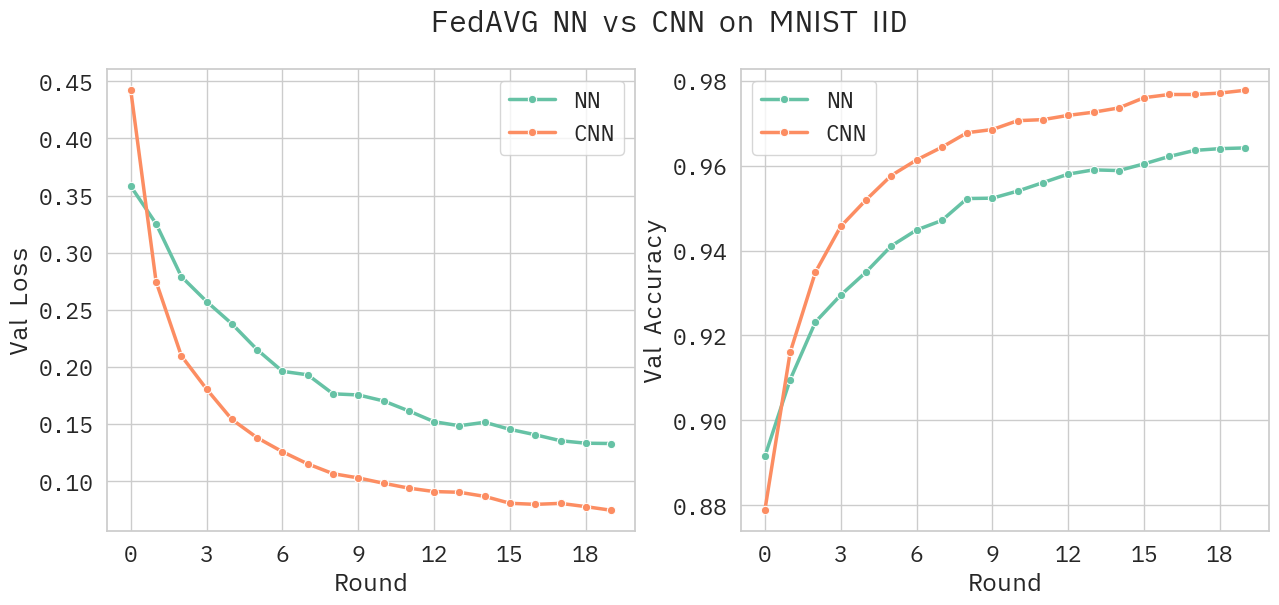

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, 'axes.labelsize': 18})
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams['font.family'] = 'iA Writer Quattro V'
i=0
for result in [result0, result1]:
    val_losses = result['val_losses']
    val_accs = result['val_accs']

    if i==0: sns.lineplot(x=range(len(val_losses)), y=val_losses, ax=axs[0], color=sns.color_palette()[i], marker='o', label='NN')
    else: sns.lineplot(x=range(len(val_losses)), y=val_losses, ax=axs[0], color=sns.color_palette()[i], marker='o', label='CNN')
    axs[0].set_xlabel('Round')
    axs[0].set_ylabel('Val Loss')

    if i==0: sns.lineplot(x=range(len(val_accs)), y=val_accs, ax=axs[1], color=sns.color_palette()[i], marker='o', label='NN')
    else: sns.lineplot(x=range(len(val_accs)), y=val_accs, ax=axs[1], color=sns.color_palette()[i], marker='o', label='CNN')
    axs[1].set_xlabel('Round')
    axs[1].set_ylabel('Val Accuracy')

    for ax in axs:
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    i+=1

    # title
    plt.suptitle('FedAVG NN vs CNN on MNIST IID')


### Varying the number of local epochs **E**
Now I compare the performance of the algorithm with different number of local epochs **E**, with C, B and K fixed. To limit the computation time I reduces the samples per client to 100. Interestingly, as shown in the paper the algorithm converge also for bigger values of E on the MNIST dataset. As we can see from the plot below, the NN model works better with low values of E, for `E=1` the algorithm converge for the NN, while it does not for the CNN. This is due to the complexity of the model, the CNN requires more local epochs to converge. With higher values of E the CNN model converge faster than the NN model.

In [8]:
results = {}
for model in [Net(), Cnn()]:
    results[model.get_type()] = {}
    for E in [1, 3, 5, 10, 15]:
        print(f'E = {E}')
        result = fedSgdPar(model=model,
                            T=20, K=100, C=0.1, E=E, B=10, num_samples=100, lr=0.1,
                            patience=15, weight_decay=10e-5, verbose=False, noiid=False)
        results[model.get_type()][E] = result

with open('results_e.json', 'w') as f:
    json.dump(results, f)


E = 1
Running the Parallel implementation FedSGD on MNIST dataset
- Parameters: T=20, K=100, C=0.1, E=1, B=10, num_samples=480, lr=0.1, weight_decay=0.0001, patience=15
- Model: Net
- Data Split:  48000 12000 10000
Using IID data


Round 0: 100%|██████████| 10/10 [00:01<00:00,  8.95it/s, loss=1.57]

Server - Val loss: 2.300, Val accuracy: 0.192


Round 1: 100%|██████████| 10/10 [00:01<00:00,  9.88it/s, loss=2.29]

Server - Val loss: 2.300, Val accuracy: 0.328


Round 2: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s, loss=2.29]

Server - Val loss: 2.298, Val accuracy: 0.403


Round 3: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s, loss=2.28]

Server - Val loss: 2.296, Val accuracy: 0.385


Round 4: 100%|██████████| 10/10 [00:01<00:00, 11.14it/s, loss=2.23]

Server - Val loss: 2.291, Val accuracy: 0.410


Round 5: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s, loss=2.14]

Server - Val loss: 2.274, Val accuracy: 0.450


Round 6: 100%|██████████| 10/10 [00:01<00:00,  9.63it/s, loss=1.99]

Server - Val loss: 2.237, Val accuracy: 0.479


Round 7: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s, loss=1.8] 

Server - Val loss: 2.210, Val accuracy: 0.544


Round 8: 100%|██████████| 10/10 [00:01<00:00, 10.36it/s, loss=1.72]

Server - Val loss: 2.126, Val accuracy: 0.583


Round 9: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s, loss=1.57]

Server - Val loss: 2.075, Val accuracy: 0.621


Round 10: 100%|██████████| 10/10 [00:01<00:00, 10.83it/s, loss=1.43]

Server - Val loss: 1.982, Val accuracy: 0.640


Round 11: 100%|██████████| 10/10 [00:01<00:00,  9.52it/s, loss=1.5] 

Server - Val loss: 1.838, Val accuracy: 0.657


Round 12: 100%|██████████| 10/10 [00:01<00:00, 11.05it/s, loss=1.3] 

Server - Val loss: 1.746, Val accuracy: 0.672


Round 13: 100%|██████████| 10/10 [00:01<00:00,  8.58it/s, loss=1.31]

Server - Val loss: 1.672, Val accuracy: 0.684


Round 14: 100%|██████████| 10/10 [00:01<00:00,  9.87it/s, loss=1.3] 

Server - Val loss: 1.553, Val accuracy: 0.692


Round 15: 100%|██████████| 10/10 [00:01<00:00,  9.63it/s, loss=1.22]

Server - Val loss: 1.425, Val accuracy: 0.703


Round 16: 100%|██████████| 10/10 [00:01<00:00,  9.74it/s, loss=1.13]

Server - Val loss: 1.366, Val accuracy: 0.713


Round 17: 100%|██████████| 10/10 [00:01<00:00,  9.48it/s, loss=1.07]

Server - Val loss: 1.238, Val accuracy: 0.729


Round 18: 100%|██████████| 10/10 [00:01<00:00,  9.04it/s, loss=1.05]

Server - Val loss: 1.175, Val accuracy: 0.736


Round 19: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s, loss=1.09]

Server - Val loss: 1.091, Val accuracy: 0.746


-- Test loss: 1.071, Test accuracy: 0.755 --
E = 3
Running the Parallel implementation FedSGD on MNIST dataset
- Parameters: T=20, K=100, C=0.1, E=3, B=10, num_samples=480, lr=0.1, weight_decay=0.0001, patience=15
- Model: Net
- Data Split:  48000 12000 10000
Using IID data


Round 0: 100%|██████████| 30/30 [00:04<00:00,  8.36it/s, loss=0.627]

Server - Val loss: 2.294, Val accuracy: 0.187


Round 1: 100%|██████████| 30/30 [00:04<00:00,  8.62it/s, loss=0.934]

Server - Val loss: 2.262, Val accuracy: 0.670


Round 2: 100%|██████████| 30/30 [00:04<00:00,  8.76it/s, loss=0.716]

Server - Val loss: 2.201, Val accuracy: 0.819


Round 3: 100%|██████████| 30/30 [00:04<00:00,  8.96it/s, loss=0.52] 

Server - Val loss: 2.114, Val accuracy: 0.852


Round 4: 100%|██████████| 30/30 [00:04<00:00,  9.56it/s, loss=0.471]

Server - Val loss: 2.029, Val accuracy: 0.862


Round 5: 100%|██████████| 30/30 [00:04<00:00,  8.78it/s, loss=0.456]

Server - Val loss: 1.789, Val accuracy: 0.870


Round 6: 100%|██████████| 30/30 [00:04<00:00, 10.72it/s, loss=0.384]

Server - Val loss: 1.516, Val accuracy: 0.873


Round 7: 100%|██████████| 30/30 [00:04<00:00,  8.73it/s, loss=0.422]

Server - Val loss: 1.466, Val accuracy: 0.876


Round 8: 100%|██████████| 30/30 [00:04<00:00, 11.05it/s, loss=0.339]

Server - Val loss: 1.190, Val accuracy: 0.878


Round 9: 100%|██████████| 30/30 [00:03<00:00, 10.82it/s, loss=0.321]

Server - Val loss: 1.102, Val accuracy: 0.880


Round 10: 100%|██████████| 30/30 [00:03<00:00,  9.92it/s, loss=0.277]

Server - Val loss: 0.944, Val accuracy: 0.881


Round 11: 100%|██████████| 30/30 [00:03<00:00,  9.88it/s, loss=0.285]

Server - Val loss: 0.790, Val accuracy: 0.885


Round 12: 100%|██████████| 30/30 [00:03<00:00,  9.99it/s, loss=0.229]

Server - Val loss: 0.688, Val accuracy: 0.887


Round 13: 100%|██████████| 30/30 [00:03<00:00, 10.03it/s, loss=0.243]

Server - Val loss: 0.628, Val accuracy: 0.888


Round 14: 100%|██████████| 30/30 [00:03<00:00, 10.93it/s, loss=0.194]

Server - Val loss: 0.545, Val accuracy: 0.890


Round 15: 100%|██████████| 30/30 [00:04<00:00,  7.98it/s, loss=0.304]

Server - Val loss: 0.470, Val accuracy: 0.892


Round 16: 100%|██████████| 30/30 [00:04<00:00,  9.37it/s, loss=0.157]

Server - Val loss: 0.451, Val accuracy: 0.892


Round 17: 100%|██████████| 30/30 [00:04<00:00,  8.95it/s, loss=0.155]

Server - Val loss: 0.415, Val accuracy: 0.894


Round 18: 100%|██████████| 30/30 [00:04<00:00,  8.93it/s, loss=0.174]

Server - Val loss: 0.397, Val accuracy: 0.895


Round 19: 100%|██████████| 30/30 [00:04<00:00,  9.71it/s, loss=0.188]

Server - Val loss: 0.374, Val accuracy: 0.896


-- Test loss: 0.345, Test accuracy: 0.906 --
E = 5
Running the Parallel implementation FedSGD on MNIST dataset
- Parameters: T=20, K=100, C=0.1, E=5, B=10, num_samples=480, lr=0.1, weight_decay=0.0001, patience=15
- Model: Net
- Data Split:  48000 12000 10000
Using IID data


Round 0: 100%|██████████| 50/50 [00:06<00:00, 10.11it/s, loss=0.0403]

Server - Val loss: 2.288, Val accuracy: 0.505


Round 1: 100%|██████████| 50/50 [00:06<00:00,  8.81it/s, loss=0.301] 

Server - Val loss: 2.239, Val accuracy: 0.850


Round 2: 100%|██████████| 50/50 [00:06<00:00,  8.31it/s, loss=0.155]

Server - Val loss: 2.148, Val accuracy: 0.878


Round 3: 100%|██████████| 50/50 [00:06<00:00,  8.57it/s, loss=0.117] 

Server - Val loss: 2.020, Val accuracy: 0.886


Round 4: 100%|██████████| 50/50 [00:07<00:00,  7.27it/s, loss=0.113] 

Server - Val loss: 1.907, Val accuracy: 0.892


Round 5: 100%|██████████| 50/50 [00:07<00:00,  8.70it/s, loss=0.128] 

Server - Val loss: 1.585, Val accuracy: 0.893


Round 6: 100%|██████████| 50/50 [00:07<00:00,  8.85it/s, loss=0.0921]

Server - Val loss: 1.228, Val accuracy: 0.895


Round 7: 100%|██████████| 50/50 [00:07<00:00,  9.10it/s, loss=0.0891]

Server - Val loss: 1.178, Val accuracy: 0.897


Round 8: 100%|██████████| 50/50 [00:06<00:00,  9.90it/s, loss=0.139] 

Server - Val loss: 0.875, Val accuracy: 0.899


Round 9: 100%|██████████| 50/50 [00:06<00:00,  8.87it/s, loss=0.161] 

Server - Val loss: 0.791, Val accuracy: 0.899


Round 10: 100%|██████████| 50/50 [00:06<00:00,  8.10it/s, loss=0.0626]

Server - Val loss: 0.643, Val accuracy: 0.901


Round 11: 100%|██████████| 50/50 [00:06<00:00,  9.00it/s, loss=0.0642]

Server - Val loss: 0.522, Val accuracy: 0.904


Round 12: 100%|██████████| 50/50 [00:06<00:00,  8.30it/s, loss=0.0293]

Server - Val loss: 0.453, Val accuracy: 0.906


Round 13: 100%|██████████| 50/50 [00:06<00:00,  9.17it/s, loss=0.0268]

Server - Val loss: 0.414, Val accuracy: 0.906


Round 14: 100%|██████████| 50/50 [00:06<00:00,  9.46it/s, loss=0.0285]

Server - Val loss: 0.368, Val accuracy: 0.907


Round 15: 100%|██████████| 50/50 [00:06<00:00,  9.50it/s, loss=0.0255]

Server - Val loss: 0.329, Val accuracy: 0.909


Round 16: 100%|██████████| 50/50 [00:06<00:00,  8.39it/s, loss=0.0665]

Server - Val loss: 0.320, Val accuracy: 0.909


Round 17: 100%|██████████| 50/50 [00:07<00:00,  9.17it/s, loss=0.0188]

Server - Val loss: 0.305, Val accuracy: 0.911


Round 18: 100%|██████████| 50/50 [00:06<00:00,  9.72it/s, loss=0.019] 

Server - Val loss: 0.298, Val accuracy: 0.911


Round 19: 100%|██████████| 50/50 [00:07<00:00,  7.92it/s, loss=0.0297]

Server - Val loss: 0.291, Val accuracy: 0.912


-- Test loss: 0.261, Test accuracy: 0.921 --
E = 10
Running the Parallel implementation FedSGD on MNIST dataset
- Parameters: T=20, K=100, C=0.1, E=10, B=10, num_samples=480, lr=0.1, weight_decay=0.0001, patience=15
- Model: Net
- Data Split:  48000 12000 10000
Using IID data


Round 0: 100%|██████████| 100/100 [00:13<00:00,  9.23it/s, loss=0.00285]

Server - Val loss: 2.285, Val accuracy: 0.572


Round 1: 100%|██████████| 100/100 [00:12<00:00,  8.48it/s, loss=0.0212] 

Server - Val loss: 2.217, Val accuracy: 0.890


Round 2: 100%|██████████| 100/100 [00:13<00:00,  8.78it/s, loss=0.0039]

Server - Val loss: 2.091, Val accuracy: 0.898


Round 3: 100%|██████████| 100/100 [00:13<00:00,  8.57it/s, loss=0.005] 

Server - Val loss: 1.923, Val accuracy: 0.901


Round 4: 100%|██████████| 100/100 [00:12<00:00,  8.40it/s, loss=0.00363]

Server - Val loss: 1.778, Val accuracy: 0.901


Round 5: 100%|██████████| 100/100 [00:14<00:00,  8.49it/s, loss=0.00416]

Server - Val loss: 1.375, Val accuracy: 0.902


Round 6: 100%|██████████| 100/100 [00:14<00:00,  7.31it/s, loss=0.00352]

Server - Val loss: 0.981, Val accuracy: 0.903


Round 7: 100%|██████████| 100/100 [00:14<00:00,  8.08it/s, loss=0.00388]

Server - Val loss: 0.934, Val accuracy: 0.904


Round 8: 100%|██████████| 100/100 [00:13<00:00,  8.60it/s, loss=0.00403]

Server - Val loss: 0.646, Val accuracy: 0.906


Round 9: 100%|██████████| 100/100 [00:13<00:00,  8.96it/s, loss=0.00323]

Server - Val loss: 0.578, Val accuracy: 0.906


Round 10: 100%|██████████| 100/100 [00:12<00:00,  7.67it/s, loss=0.00356]

Server - Val loss: 0.468, Val accuracy: 0.907


Round 11: 100%|██████████| 100/100 [00:13<00:00,  7.49it/s, loss=0.0036] 

Server - Val loss: 0.387, Val accuracy: 0.910


Round 12: 100%|██████████| 100/100 [00:14<00:00,  9.19it/s, loss=0.00298]

Server - Val loss: 0.346, Val accuracy: 0.911


Round 13: 100%|██████████| 100/100 [00:13<00:00,  8.25it/s, loss=0.00322]

Server - Val loss: 0.325, Val accuracy: 0.911


Round 14: 100%|██████████| 100/100 [00:14<00:00,  7.51it/s, loss=0.00456]

Server - Val loss: 0.303, Val accuracy: 0.912


Round 15: 100%|██████████| 100/100 [00:13<00:00,  8.55it/s, loss=0.00301]

Server - Val loss: 0.288, Val accuracy: 0.913


Round 16: 100%|██████████| 100/100 [00:12<00:00,  8.03it/s, loss=0.00281]

Server - Val loss: 0.284, Val accuracy: 0.914


Round 17: 100%|██████████| 100/100 [00:13<00:00,  7.98it/s, loss=0.00206]

Server - Val loss: 0.280, Val accuracy: 0.914


Round 18: 100%|██████████| 100/100 [00:13<00:00,  9.00it/s, loss=0.00253]

Server - Val loss: 0.278, Val accuracy: 0.915


Round 19: 100%|██████████| 100/100 [00:12<00:00,  8.97it/s, loss=0.00348]

Server - Val loss: 0.278, Val accuracy: 0.916


-- Test loss: 0.247, Test accuracy: 0.925 --
E = 15
Running the Parallel implementation FedSGD on MNIST dataset
- Parameters: T=20, K=100, C=0.1, E=15, B=10, num_samples=480, lr=0.1, weight_decay=0.0001, patience=15
- Model: Net
- Data Split:  48000 12000 10000
Using IID data


Round 0: 100%|██████████| 150/150 [00:19<00:00, 10.06it/s, loss=0.00157]

Server - Val loss: 2.284, Val accuracy: 0.629


Round 1: 100%|██████████| 150/150 [00:19<00:00,  9.83it/s, loss=0.00239]

Server - Val loss: 2.209, Val accuracy: 0.898


Round 2: 100%|██████████| 150/150 [00:19<00:00,  9.11it/s, loss=0.00174]

Server - Val loss: 2.072, Val accuracy: 0.902


Round 3: 100%|██████████| 150/150 [00:20<00:00,  8.97it/s, loss=0.00195]

Server - Val loss: 1.891, Val accuracy: 0.903


Round 4: 100%|██████████| 150/150 [00:18<00:00,  9.27it/s, loss=0.00184]

Server - Val loss: 1.738, Val accuracy: 0.903


Round 5: 100%|██████████| 150/150 [00:19<00:00,  9.40it/s, loss=0.002]  

Server - Val loss: 1.314, Val accuracy: 0.904


Round 6: 100%|██████████| 150/150 [00:19<00:00,  9.63it/s, loss=0.00182]

Server - Val loss: 0.911, Val accuracy: 0.905


Round 7: 100%|██████████| 150/150 [00:18<00:00,  9.95it/s, loss=0.00201]

Server - Val loss: 0.866, Val accuracy: 0.906


Round 8: 100%|██████████| 150/150 [00:20<00:00,  7.78it/s, loss=0.00206]

Server - Val loss: 0.588, Val accuracy: 0.908


Round 9: 100%|██████████| 150/150 [00:20<00:00,  8.94it/s, loss=0.00175]

Server - Val loss: 0.526, Val accuracy: 0.909


Round 10: 100%|██████████| 150/150 [00:20<00:00,  9.83it/s, loss=0.00175]

Server - Val loss: 0.427, Val accuracy: 0.910


Round 11: 100%|██████████| 150/150 [00:19<00:00,  9.22it/s, loss=0.00196]

Server - Val loss: 0.358, Val accuracy: 0.912


Round 12: 100%|██████████| 150/150 [00:19<00:00,  9.16it/s, loss=0.0018] 

Server - Val loss: 0.323, Val accuracy: 0.912


Round 13: 100%|██████████| 150/150 [00:20<00:00,  8.19it/s, loss=0.0018] 

Server - Val loss: 0.307, Val accuracy: 0.913


Round 14: 100%|██████████| 150/150 [00:20<00:00,  7.23it/s, loss=0.00221]

Server - Val loss: 0.290, Val accuracy: 0.914


Round 15: 100%|██████████| 150/150 [00:20<00:00,  7.85it/s, loss=0.00151]

Server - Val loss: 0.280, Val accuracy: 0.915


Round 16: 100%|██████████| 150/150 [00:20<00:00,  8.09it/s, loss=0.00149]

Server - Val loss: 0.278, Val accuracy: 0.915


Round 17: 100%|██████████| 150/150 [00:20<00:00,  8.20it/s, loss=0.00134]

Server - Val loss: 0.276, Val accuracy: 0.917


Round 18: 100%|██████████| 150/150 [00:19<00:00,  7.88it/s, loss=0.0014] 

Server - Val loss: 0.275, Val accuracy: 0.917


Round 19: 100%|██████████| 150/150 [00:21<00:00,  7.60it/s, loss=0.00163]

Server - Val loss: 0.277, Val accuracy: 0.918


-- Test loss: 0.244, Test accuracy: 0.927 --
E = 1
Running the Parallel implementation FedSGD on MNIST dataset
- Parameters: T=20, K=100, C=0.1, E=1, B=10, num_samples=480, lr=0.1, weight_decay=0.0001, patience=15
- Model: Cnn
- Data Split:  48000 12000 10000
Using IID data


Round 0: 100%|██████████| 10/10 [00:02<00:00,  7.06it/s, loss=1.99]

Server - Val loss: 2.302, Val accuracy: 0.102


Round 1: 100%|██████████| 10/10 [00:02<00:00,  6.52it/s, loss=2.3] 

Server - Val loss: 2.302, Val accuracy: 0.107


Round 2: 100%|██████████| 10/10 [00:02<00:00,  5.52it/s, loss=2.3]

Server - Val loss: 2.302, Val accuracy: 0.107


Round 3: 100%|██████████| 10/10 [00:02<00:00,  6.62it/s, loss=2.3]

Server - Val loss: 2.302, Val accuracy: 0.113


Round 4: 100%|██████████| 10/10 [00:02<00:00,  5.45it/s, loss=2.3]

Server - Val loss: 2.302, Val accuracy: 0.113


Round 5: 100%|██████████| 10/10 [00:02<00:00,  2.92it/s, loss=2.3]

Server - Val loss: 2.302, Val accuracy: 0.113


Round 6: 100%|██████████| 10/10 [00:02<00:00,  7.47it/s, loss=2.3]

Server - Val loss: 2.302, Val accuracy: 0.113


Round 7: 100%|██████████| 10/10 [00:02<00:00,  5.94it/s, loss=2.3]

Server - Val loss: 2.302, Val accuracy: 0.113


Round 8: 100%|██████████| 10/10 [00:02<00:00,  7.02it/s, loss=2.3]

Server - Val loss: 2.302, Val accuracy: 0.113


Round 9: 100%|██████████| 10/10 [00:02<00:00,  5.64it/s, loss=2.3]

Server - Val loss: 2.302, Val accuracy: 0.113


Round 10: 100%|██████████| 10/10 [00:02<00:00,  5.76it/s, loss=2.3]

Server - Val loss: 2.301, Val accuracy: 0.113


Round 11: 100%|██████████| 10/10 [00:02<00:00,  5.98it/s, loss=2.3]

Server - Val loss: 2.301, Val accuracy: 0.113


Round 12: 100%|██████████| 10/10 [00:02<00:00,  6.51it/s, loss=2.3]

Server - Val loss: 2.301, Val accuracy: 0.113


Round 13: 100%|██████████| 10/10 [00:02<00:00,  6.67it/s, loss=2.3]

Server - Val loss: 2.301, Val accuracy: 0.113


Round 14: 100%|██████████| 10/10 [00:02<00:00,  7.05it/s, loss=2.3]

Server - Val loss: 2.301, Val accuracy: 0.113


Round 15: 100%|██████████| 10/10 [00:02<00:00,  5.04it/s, loss=2.3]

Server - Val loss: 2.301, Val accuracy: 0.113


Round 16: 100%|██████████| 10/10 [00:02<00:00,  7.23it/s, loss=2.3]

Server - Val loss: 2.301, Val accuracy: 0.113


Round 17: 100%|██████████| 10/10 [00:02<00:00,  5.33it/s, loss=2.3]

Server - Val loss: 2.301, Val accuracy: 0.113


Round 18: 100%|██████████| 10/10 [00:02<00:00,  6.24it/s, loss=2.3]

Server - Val loss: 2.301, Val accuracy: 0.113


Round 19: 100%|██████████| 10/10 [00:02<00:00,  6.26it/s, loss=2.3]

Server - Val loss: 2.301, Val accuracy: 0.113


-- Test loss: 2.301, Test accuracy: 0.113 --
E = 3
Running the Parallel implementation FedSGD on MNIST dataset
- Parameters: T=20, K=100, C=0.1, E=3, B=10, num_samples=480, lr=0.1, weight_decay=0.0001, patience=15
- Model: Cnn
- Data Split:  48000 12000 10000
Using IID data


Round 0: 100%|██████████| 30/30 [00:06<00:00,  5.87it/s, loss=2.28]

Server - Val loss: 2.302, Val accuracy: 0.113


Round 1: 100%|██████████| 30/30 [00:06<00:00,  6.67it/s, loss=2.3] 

Server - Val loss: 2.302, Val accuracy: 0.113


Round 2: 100%|██████████| 30/30 [00:06<00:00,  6.43it/s, loss=2.3] 

Server - Val loss: 2.302, Val accuracy: 0.113


Round 3: 100%|██████████| 30/30 [00:06<00:00,  7.69it/s, loss=2.3] 

Server - Val loss: 2.302, Val accuracy: 0.113


Round 4: 100%|██████████| 30/30 [00:06<00:00,  6.33it/s, loss=2.3] 

Server - Val loss: 2.302, Val accuracy: 0.113


Round 5: 100%|██████████| 30/30 [00:06<00:00,  6.24it/s, loss=2.29]

Server - Val loss: 2.302, Val accuracy: 0.113


Round 6: 100%|██████████| 30/30 [00:06<00:00,  6.82it/s, loss=2.29]

Server - Val loss: 2.301, Val accuracy: 0.113


Round 7: 100%|██████████| 30/30 [00:07<00:00,  6.12it/s, loss=2.28]

Server - Val loss: 2.301, Val accuracy: 0.113


Round 8: 100%|██████████| 30/30 [00:06<00:00,  6.42it/s, loss=1.99]

Server - Val loss: 2.296, Val accuracy: 0.113


Round 9: 100%|██████████| 30/30 [00:07<00:00,  6.18it/s, loss=0.801]

Server - Val loss: 2.286, Val accuracy: 0.119


Round 10: 100%|██████████| 30/30 [00:06<00:00,  6.56it/s, loss=0.569]

Server - Val loss: 2.261, Val accuracy: 0.385


Round 11: 100%|██████████| 30/30 [00:06<00:00,  6.35it/s, loss=0.445]

Server - Val loss: 2.198, Val accuracy: 0.724


Round 12: 100%|██████████| 30/30 [00:06<00:00,  5.78it/s, loss=0.49] 

Server - Val loss: 2.136, Val accuracy: 0.837


Round 13: 100%|██████████| 30/30 [00:06<00:00,  6.59it/s, loss=0.387]

Server - Val loss: 2.070, Val accuracy: 0.874


Round 14: 100%|██████████| 30/30 [00:06<00:00,  6.51it/s, loss=0.257]

Server - Val loss: 1.896, Val accuracy: 0.902


Round 15: 100%|██████████| 30/30 [00:06<00:00,  5.43it/s, loss=0.14] 

Server - Val loss: 1.697, Val accuracy: 0.915


Round 16: 100%|██████████| 30/30 [00:06<00:00,  6.47it/s, loss=0.251]

Server - Val loss: 1.572, Val accuracy: 0.923


Round 17: 100%|██████████| 30/30 [00:06<00:00,  5.74it/s, loss=0.142]

Server - Val loss: 1.285, Val accuracy: 0.929


Round 18: 100%|██████████| 30/30 [00:06<00:00,  5.66it/s, loss=0.14] 

Server - Val loss: 1.147, Val accuracy: 0.936


Round 19: 100%|██████████| 30/30 [00:06<00:00,  6.73it/s, loss=0.193] 

Server - Val loss: 0.976, Val accuracy: 0.940


-- Test loss: 0.949, Test accuracy: 0.943 --
E = 5
Running the Parallel implementation FedSGD on MNIST dataset
- Parameters: T=20, K=100, C=0.1, E=5, B=10, num_samples=480, lr=0.1, weight_decay=0.0001, patience=15
- Model: Cnn
- Data Split:  48000 12000 10000
Using IID data


Round 0: 100%|██████████| 50/50 [00:10<00:00,  5.74it/s, loss=0.0798] 

Server - Val loss: 2.300, Val accuracy: 0.110


Round 1: 100%|██████████| 50/50 [00:10<00:00,  5.88it/s, loss=0.145] 

Server - Val loss: 2.286, Val accuracy: 0.411


Round 2: 100%|██████████| 50/50 [00:10<00:00,  5.15it/s, loss=0.137]

Server - Val loss: 2.258, Val accuracy: 0.697


Round 3: 100%|██████████| 50/50 [00:10<00:00,  5.02it/s, loss=0.109] 

Server - Val loss: 2.203, Val accuracy: 0.880


Round 4: 100%|██████████| 50/50 [00:10<00:00,  5.55it/s, loss=0.0463]

Server - Val loss: 2.135, Val accuracy: 0.924


Round 5: 100%|██████████| 50/50 [00:10<00:00,  5.94it/s, loss=0.202] 

Server - Val loss: 1.919, Val accuracy: 0.945


Round 6: 100%|██████████| 50/50 [00:11<00:00,  5.65it/s, loss=0.0464]

Server - Val loss: 1.578, Val accuracy: 0.950


Round 7: 100%|██████████| 50/50 [00:10<00:00,  5.13it/s, loss=0.0602]

Server - Val loss: 1.508, Val accuracy: 0.952


Round 8: 100%|██████████| 50/50 [00:10<00:00,  5.01it/s, loss=0.0367] 

Server - Val loss: 1.102, Val accuracy: 0.955


Round 9: 100%|██████████| 50/50 [00:10<00:00,  5.97it/s, loss=0.00917]

Server - Val loss: 0.986, Val accuracy: 0.954


Round 10: 100%|██████████| 50/50 [00:11<00:00,  6.13it/s, loss=0.0882] 

Server - Val loss: 0.743, Val accuracy: 0.956


Round 11: 100%|██████████| 50/50 [00:10<00:00,  5.45it/s, loss=0.0436] 

Server - Val loss: 0.524, Val accuracy: 0.958


Round 12: 100%|██████████| 50/50 [00:10<00:00,  5.24it/s, loss=0.0083] 

Server - Val loss: 0.404, Val accuracy: 0.959


Round 13: 100%|██████████| 50/50 [00:10<00:00,  5.46it/s, loss=0.0278] 

Server - Val loss: 0.335, Val accuracy: 0.960


Round 14: 100%|██████████| 50/50 [00:11<00:00,  5.08it/s, loss=0.0129] 

Server - Val loss: 0.251, Val accuracy: 0.961


Round 15: 100%|██████████| 50/50 [00:10<00:00,  5.76it/s, loss=0.0293] 

Server - Val loss: 0.183, Val accuracy: 0.961


Round 16: 100%|██████████| 50/50 [00:11<00:00,  5.43it/s, loss=0.0497] 

Server - Val loss: 0.179, Val accuracy: 0.961


Round 17: 100%|██████████| 50/50 [00:10<00:00,  6.08it/s, loss=0.00293]

Server - Val loss: 0.153, Val accuracy: 0.962


Round 18: 100%|██████████| 50/50 [00:11<00:00,  5.44it/s, loss=0.0451] 

Server - Val loss: 0.143, Val accuracy: 0.963


Round 19: 100%|██████████| 50/50 [00:11<00:00,  5.06it/s, loss=0.00258]

Server - Val loss: 0.130, Val accuracy: 0.964


-- Test loss: 0.112, Test accuracy: 0.966 --
E = 10
Running the Parallel implementation FedSGD on MNIST dataset
- Parameters: T=20, K=100, C=0.1, E=10, B=10, num_samples=480, lr=0.1, weight_decay=0.0001, patience=15
- Model: Cnn
- Data Split:  48000 12000 10000
Using IID data


Round 0: 100%|██████████| 100/100 [00:21<00:00,  4.80it/s, loss=0.000479]

Server - Val loss: 2.299, Val accuracy: 0.185


Round 1: 100%|██████████| 100/100 [00:22<00:00,  4.31it/s, loss=0.000714]

Server - Val loss: 2.280, Val accuracy: 0.509


Round 2: 100%|██████████| 100/100 [00:21<00:00,  4.49it/s, loss=0.000853]

Server - Val loss: 2.231, Val accuracy: 0.891


Round 3: 100%|██████████| 100/100 [00:21<00:00,  4.55it/s, loss=0.000866]

Server - Val loss: 2.150, Val accuracy: 0.937


Round 4: 100%|██████████| 100/100 [00:21<00:00,  4.47it/s, loss=0.000535]

Server - Val loss: 2.072, Val accuracy: 0.949


Round 5: 100%|██████████| 100/100 [00:21<00:00,  4.50it/s, loss=0.000667]

Server - Val loss: 1.759, Val accuracy: 0.954


Round 6: 100%|██████████| 100/100 [00:22<00:00,  4.71it/s, loss=0.0165]  

Server - Val loss: 1.326, Val accuracy: 0.956


Round 7: 100%|██████████| 100/100 [00:21<00:00,  4.37it/s, loss=0.000654]

Server - Val loss: 1.260, Val accuracy: 0.958


Round 8: 100%|██████████| 100/100 [00:22<00:00,  4.26it/s, loss=0.000505]

Server - Val loss: 0.826, Val accuracy: 0.958


Round 9: 100%|██████████| 100/100 [00:21<00:00,  4.43it/s, loss=0.000628]

Server - Val loss: 0.690, Val accuracy: 0.959


Round 10: 100%|██████████| 100/100 [00:21<00:00,  4.48it/s, loss=0.000532]

Server - Val loss: 0.483, Val accuracy: 0.960


Round 11: 100%|██████████| 100/100 [00:22<00:00,  4.74it/s, loss=0.000545]

Server - Val loss: 0.321, Val accuracy: 0.962


Round 12: 100%|██████████| 100/100 [00:22<00:00,  4.26it/s, loss=0.000485]

Server - Val loss: 0.248, Val accuracy: 0.963


Round 13: 100%|██████████| 100/100 [00:20<00:00,  6.23it/s, loss=0.000667]

Server - Val loss: 0.205, Val accuracy: 0.964


Round 14: 100%|██████████| 100/100 [00:21<00:00,  4.40it/s, loss=0.000535]

Server - Val loss: 0.158, Val accuracy: 0.965


Round 15: 100%|██████████| 100/100 [00:21<00:00,  4.49it/s, loss=0.000481]

Server - Val loss: 0.128, Val accuracy: 0.965


Round 16: 100%|██████████| 100/100 [00:22<00:00,  4.59it/s, loss=0.000602]

Server - Val loss: 0.122, Val accuracy: 0.965


Round 17: 100%|██████████| 100/100 [00:22<00:00,  4.53it/s, loss=0.000571]

Server - Val loss: 0.113, Val accuracy: 0.966


Round 18: 100%|██████████| 100/100 [00:21<00:00,  4.80it/s, loss=0.000465]

Server - Val loss: 0.109, Val accuracy: 0.966


Round 19: 100%|██████████| 100/100 [00:21<00:00,  4.46it/s, loss=0.000489]

Server - Val loss: 0.106, Val accuracy: 0.967


-- Test loss: 0.088, Test accuracy: 0.971 --
E = 15
Running the Parallel implementation FedSGD on MNIST dataset
- Parameters: T=20, K=100, C=0.1, E=15, B=10, num_samples=480, lr=0.1, weight_decay=0.0001, patience=15
- Model: Cnn
- Data Split:  48000 12000 10000
Using IID data


Round 0: 100%|██████████| 150/150 [00:32<00:00,  4.37it/s, loss=0.000297]

Server - Val loss: 2.299, Val accuracy: 0.198


Round 1: 100%|██████████| 150/150 [00:33<00:00,  4.03it/s, loss=0.00054] 

Server - Val loss: 2.280, Val accuracy: 0.589


Round 2: 100%|██████████| 150/150 [00:32<00:00,  4.14it/s, loss=0.000413]

Server - Val loss: 2.235, Val accuracy: 0.898


Round 3: 100%|██████████| 150/150 [00:32<00:00,  4.26it/s, loss=0.000382]

Server - Val loss: 2.146, Val accuracy: 0.942


Round 4: 100%|██████████| 150/150 [00:33<00:00,  4.32it/s, loss=0.000306]

Server - Val loss: 2.034, Val accuracy: 0.954


Round 5: 100%|██████████| 150/150 [00:32<00:00,  4.08it/s, loss=0.000457]

Server - Val loss: 1.694, Val accuracy: 0.959


Round 6: 100%|██████████| 150/150 [00:32<00:00,  3.98it/s, loss=0.00041] 

Server - Val loss: 1.235, Val accuracy: 0.960


Round 7: 100%|██████████| 150/150 [00:34<00:00,  4.17it/s, loss=0.00027] 

Server - Val loss: 1.161, Val accuracy: 0.960


Round 8: 100%|██████████| 150/150 [00:32<00:00,  4.24it/s, loss=0.000322]

Server - Val loss: 0.730, Val accuracy: 0.961


Round 9: 100%|██████████| 150/150 [00:33<00:00,  4.27it/s, loss=0.000425]

Server - Val loss: 0.606, Val accuracy: 0.961


Round 10: 100%|██████████| 150/150 [00:31<00:00,  4.04it/s, loss=0.000255]

Server - Val loss: 0.431, Val accuracy: 0.962


Round 11: 100%|██████████| 150/150 [00:31<00:00,  4.07it/s, loss=0.000383]

Server - Val loss: 0.294, Val accuracy: 0.962


Round 12: 100%|██████████| 150/150 [00:33<00:00,  4.13it/s, loss=0.000276]

Server - Val loss: 0.227, Val accuracy: 0.962


Round 13: 100%|██████████| 150/150 [00:32<00:00,  4.35it/s, loss=0.00208] 

Server - Val loss: 0.205, Val accuracy: 0.963


Round 14: 100%|██████████| 150/150 [00:33<00:00,  4.04it/s, loss=0.000374]

Server - Val loss: 0.161, Val accuracy: 0.964


Round 15: 100%|██████████| 150/150 [00:33<00:00,  4.02it/s, loss=0.000308]

Server - Val loss: 0.128, Val accuracy: 0.964


Round 16: 100%|██████████| 150/150 [00:33<00:00,  4.17it/s, loss=0.000319]

Server - Val loss: 0.122, Val accuracy: 0.965


Round 17: 100%|██████████| 150/150 [00:33<00:00,  4.01it/s, loss=0.000261]

Server - Val loss: 0.111, Val accuracy: 0.966


Round 18: 100%|██████████| 150/150 [00:33<00:00,  4.14it/s, loss=0.000292]

Server - Val loss: 0.106, Val accuracy: 0.967


Round 19: 100%|██████████| 150/150 [00:31<00:00,  4.17it/s, loss=0.000312]

Server - Val loss: 0.104, Val accuracy: 0.968


-- Test loss: 0.086, Test accuracy: 0.972 --


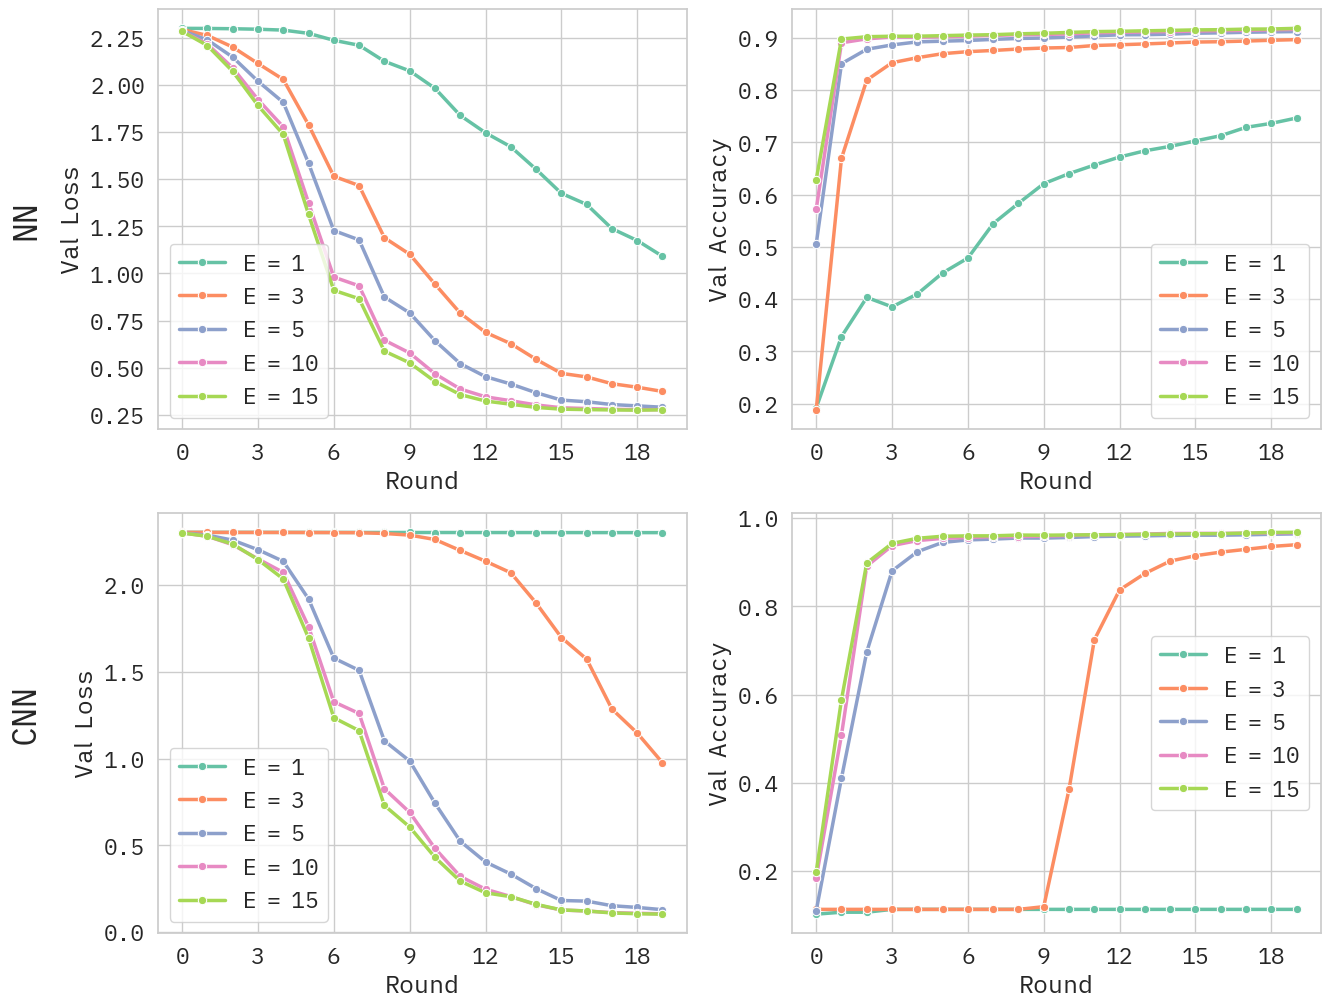

In [65]:
# plot results
results = json.load(open('results/results_e.json'))

# plot 2 figures
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, 'axes.labelsize': 18})
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams['font.family'] = 'iA Writer Quattro V'

import warnings

from sympy import rotations
warnings.filterwarnings("ignore")

for i, model in enumerate(results.keys()):
    for j, E in enumerate(results[model].keys()):
        val_losses = results[model][E]['val_losses']
        val_accs = results[model][E]['val_accs']
        sns.lineplot(x=range(len(val_losses)), y=val_losses, ax=axs[i, 0], color=sns.color_palette()[j], marker='o', label=f'E = {E}')
        sns.lineplot(x=range(len(val_accs)), y=val_accs, ax=axs[i, 1], color=sns.color_palette()[j], marker='o', label=f'E = {E}')
        # set axis labels
        axs[i, 0].set_xlabel('Round')
        axs[i, 0].set_ylabel('Val Loss')
        axs[i, 1].set_xlabel('Round')
        axs[i, 1].set_ylabel('Val Accuracy')
        # move title to the left of the plot
        axs[i,0].set_title("NN" if model == "Net" else "CNN", rotation='vertical', x=-0.25, y=0.45, loc='center', fontsize=24, fontweight='bold')

for ax in axs.flatten():
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.legend()

plt.show()

### Varying the number of clients per round **C**
In this experiment I compare the performance of the algorithm with different number of clients per round **C**, with E, B and K fixed. As we can see from the plot below, the algorithm converge faster with higher values of C. This is due to the fact that more clients are involved in the training at each round and the server has more models to average. At each round the training is performed on a bigger dataset. Increasing C means higher degree of parallelism but also higher communication cost. As we can see `C=0.1` is a good tradeoff between accuracy and computation cost, it is faster than `C=0` and `C=1` and it does not differ much from higher values of C.

In [84]:
results = {}
for model in [Net(), Cnn()]:
    results[model.get_type()] = {}
    for C in [0, 0.1, 0.2, 0.5]:
        print(f'C = {C}')
        result = fedSgdPar(model=model,
                            T=20, K=100, C=C, E=5, B=10, num_samples=100, lr=0.01,
                            patience=20, weight_decay=10e-5, verbose=False, noiid=False)
        results[model.get_type()][C] = result

with open('results/results_c.json', 'w') as f:
    json.dump(results, f)

C = 0


-- Test loss: 0.408, Test accuracy: 0.880 --
C = 0.1


-- Test loss: 0.287, Test accuracy: 0.917 --
C = 0.2


-- Test loss: 0.259, Test accuracy: 0.927 --
C = 0.5


-- Test loss: 0.243, Test accuracy: 0.931 --
C = 0


-- Test loss: 0.214, Test accuracy: 0.933 --
C = 0.1


-- Test loss: 0.115, Test accuracy: 0.964 --
C = 0.2


-- Test loss: 0.091, Test accuracy: 0.973 --
C = 0.5


-- Test loss: 0.079, Test accuracy: 0.977 --


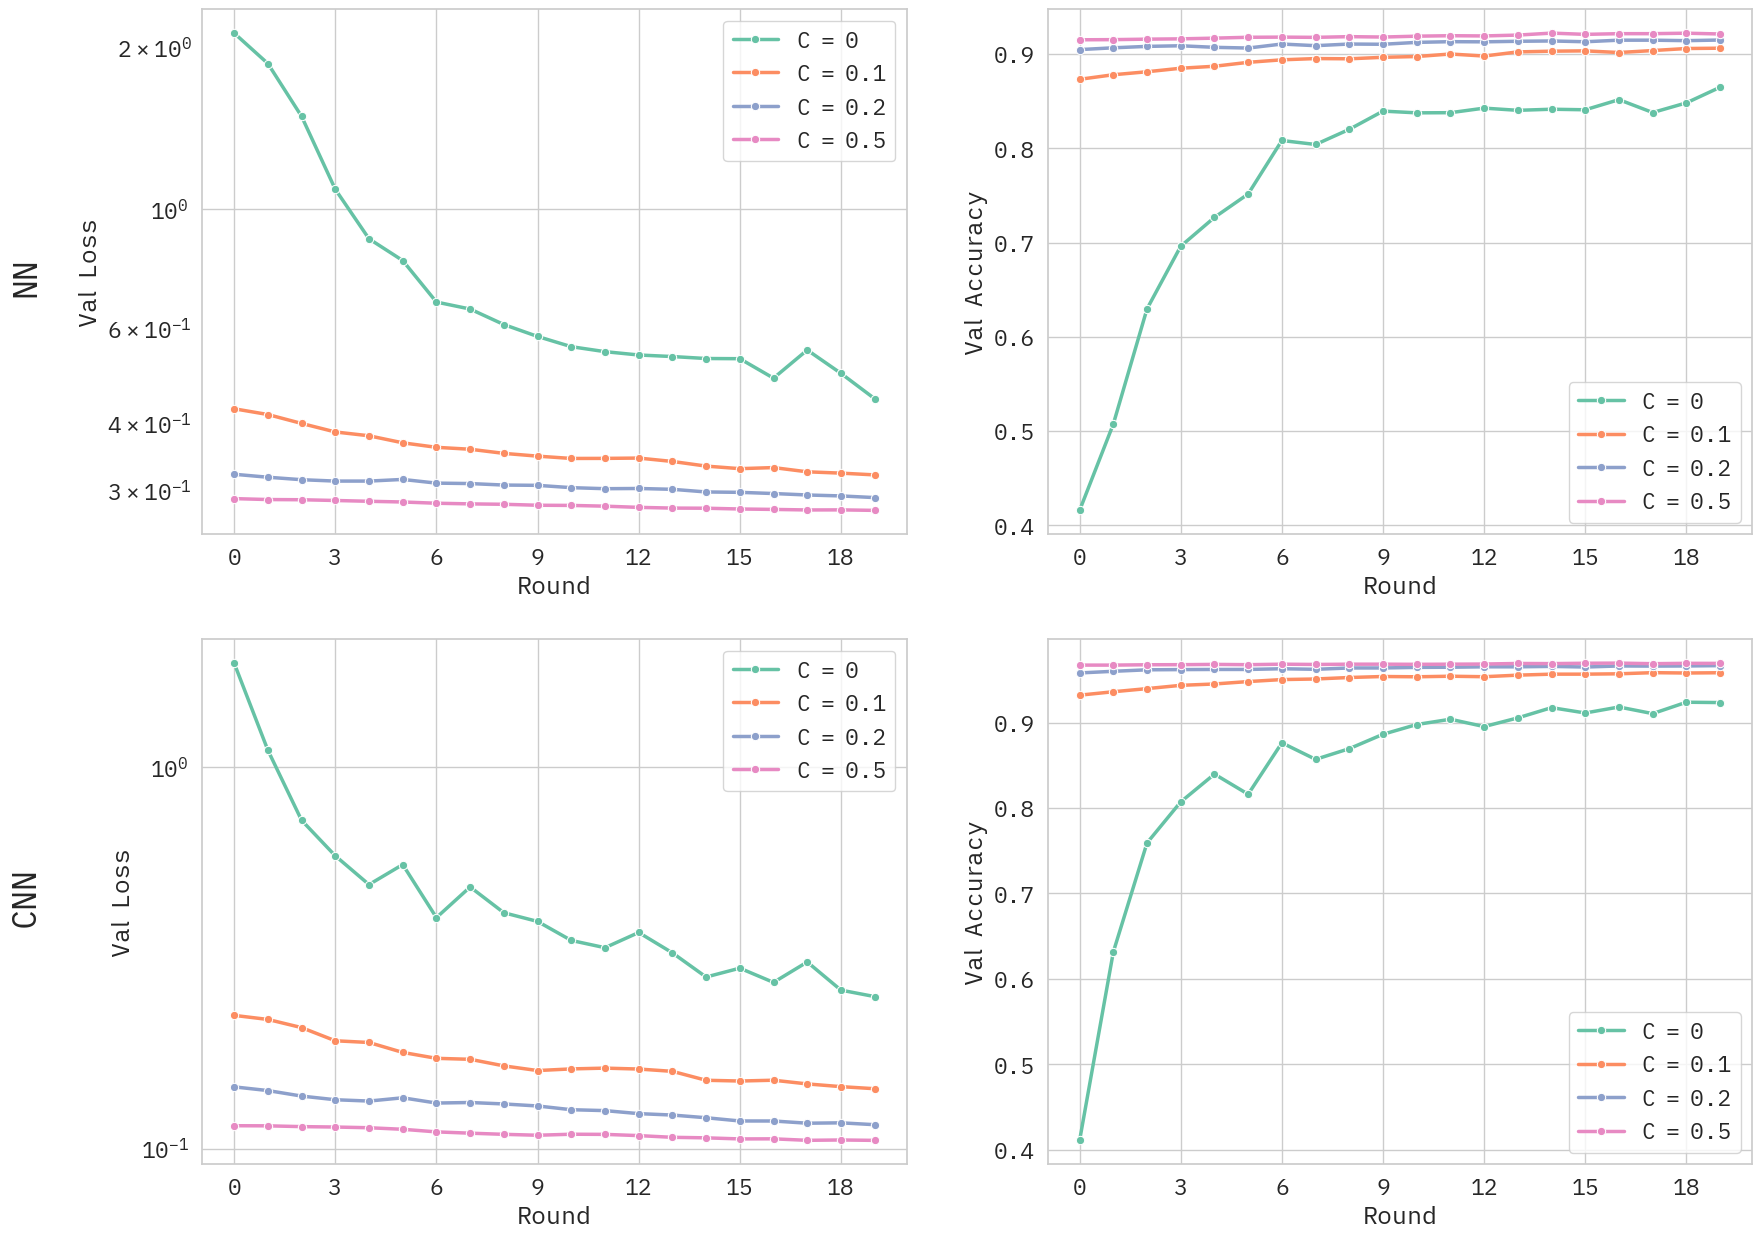

In [91]:
# plot results
results = json.load(open('results/results_c.json'))

# plot 2 figures
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, 'axes.labelsize': 18})
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams['font.family'] = 'iA Writer Quattro V'

import warnings

from sympy import rotations
warnings.filterwarnings("ignore")

for i, model in enumerate(results.keys()):
    for j, C in enumerate(results[model].keys()):
        val_losses = results[model][C]['val_losses']
        val_accs = results[model][C]['val_accs']
        sns.lineplot(x=range(len(val_losses)), y=val_losses, ax=axs[i, 0], color=sns.color_palette()[j], marker='o', label=f'C = {C}')
        sns.lineplot(x=range(len(val_accs)), y=val_accs, ax=axs[i, 1], color=sns.color_palette()[j], marker='o', label=f'C = {C}')
        # set axis labels
        axs[i, 0].set_xlabel('Round')
        axs[i, 0].set_ylabel('Val Loss')
        axs[i, 1].set_xlabel('Round')
        axs[i, 1].set_ylabel('Val Accuracy')
        # move title to the left of the plot
        axs[i,0].set_title("NN" if model == "Net" else "CNN", rotation='vertical', x=-0.25, y=0.45, loc='center', fontsize=24, fontweight='bold')
        # set y scake
        axs[i, 0].set_yscale('log')
        #axs[i, 1].set_yscale('log')

for ax in axs.flatten():
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.legend()

plt.show()

### Non-IID data

Finally, I tried dealing with the **non-IID** data distribution problem. In the previous experiments the data was distributed uniformly among the clients, but in real scenarios the data is not distributed uniformly. In this case each client has only one digit data. Due to the data preprocessing overhead, I tested the algorithm with few sample using `num_samples=20` and `K=10`. As we can see from the plot below, the algorithm converge slower than the IID data distribution, but it still converge. The CNN model is more robust to the non-IID data distribution than the NN model that tends to overfit more.

In [71]:
result_nn_noniid = fedSgdPar(model=Net(), T=20, K=10, C=1, E=5, B=1,
                     num_samples=20, lr=0.001, patience=5, weight_decay=10e-3, noiid=True, verbose=False)

-- Test loss: 1.707, Test accuracy: 0.675 --


In [73]:
result_cnn_noniid = fedSgdPar(model=Cnn(), T=20, K=10, C=1, E=5, B=1,
                        num_samples=20, lr=0.001, patience=5, weight_decay=10e-3, noiid=True, verbose=False)

-- Test loss: 1.909, Test accuracy: 0.575 --


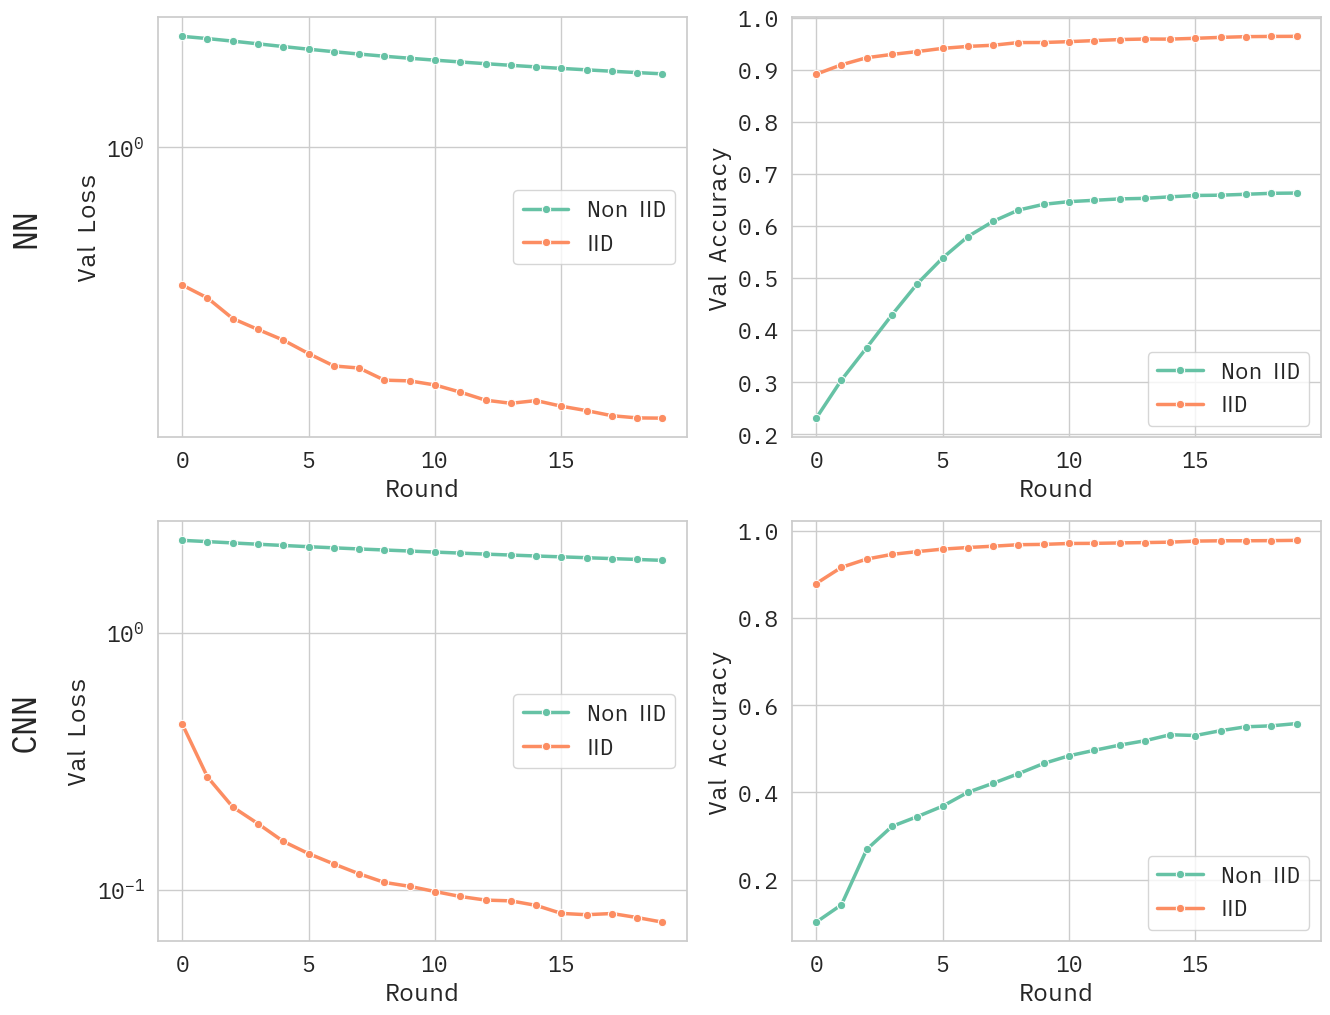

In [83]:
# plot non iid training vs iid training for CNN and NN
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, 'axes.labelsize': 18})
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams['font.family'] = 'iA Writer Quattro V'

# plot 4 figures
# first row: NN iid vs NN non iid
# second row: CNN iid vs CNN non iid
# each row has 2 columns: val loss and val accuracy

result_iid = [result0, result1]

for i, result in enumerate([result_nn_noniid, result_cnn_noniid]):
    val_losses = result['val_losses']
    val_accs = result['val_accs']
    val_losses_iid = result_iid[i]['val_losses']
    val_accs_iid = result_iid[i]['val_accs']
    sns.lineplot(x=range(len(val_losses)), y=val_losses, ax=axs[i, 0], color=sns.color_palette()[0], marker='o', label='Non IID')
    sns.lineplot(x=range(len(val_accs)), y=val_accs, ax=axs[i, 1], color=sns.color_palette()[0], marker='o', label='Non IID')
    sns.lineplot(x=range(len(val_losses_iid)), y=val_losses_iid, ax=axs[i, 0], color=sns.color_palette()[1], marker='o', label='IID')
    sns.lineplot(x=range(len(val_accs_iid)), y=val_accs_iid, ax=axs[i, 1], color=sns.color_palette()[1], marker='o', label='IID')
    # set axis labels
    axs[i, 0].set_xlabel('Round')
    axs[i, 0].set_ylabel('Val Loss')
    axs[i, 1].set_xlabel('Round')
    axs[i, 1].set_ylabel('Val Accuracy')
    # set yscale
    axs[i, 0].set_yscale('log')
    axs[j, 0].set_yscale('log')
    # move title to the left of the plot
    axs[i,0].set_title("NN" if i == 0 else "CNN", rotation='vertical', x=-0.25, y=0.45, loc='center', fontsize=24, fontweight='bold')

## Considerations

I implemented the Federated Learning algorithm **FedAvg** on the MNIST dataset using Pytorch and I successfully replicated the results of the paper [1]. I showed how the algorithm performs better with more local epochs and how it can deal with the non-IID data distribution problem. It was interesting to see how the algorithm can be used to train a model on a decentralized dataset, without the need to share the data between the clients, but still converging to a good global model.

Due to time constraints I kept the number of comunication rounds low, enough to see the convergence of the algorithm in the optimal configurations. More exploration could be done on the hyperparameters tuning and I could had increase the number of comunication rounds, in order to improve the accuracy on the test set. In particular the algorithm needs more rounds to converge for the non-IID data and the FedSGD version. I found the algorithm converges faster with more clients and small batche size, as shown in the paper. In this sense the `C` parameter is fundamental, because it allows to reduce the number of clients that train at each round, acting as a regularization technique and reducing the computational cost. With `C=0.1` I was able to train the model on all the trainset reaching an accuracy of 96% on the test set in only 6 rounds and 98% in 20 rounds for the CNN model.

I found this project really interesting, it gave me the opportunity to understand better the Federated Learning approach and I improved my Pytorch skills. I also learned how to use the joblib module to parallelize the training of the clients. The limited computational power and time allowed me to explore the fastest converging configurations and it was interesting finding the right trade-off. In future I would like to explore the improved version of the algorithm.


## References
[1] [H. B. McMahan, E. Moore, D. Ramage, S. Hampson, and B. A. y Arcas, Communication-Efficient Learning of Deep Networks from Decentralized Data. 2023.](https://arxiv.org/abs/1602.05629)